In [1]:
from os import path
import matplotlib.pyplot as plt
import numpy as np

# All packages below are available at http://purl.org/cappellari/software
from plotbin.plot_velfield import plot_velfield
from plotbin.symmetrize_velfield import symmetrize_velfield
import jampy as jam_package
from jampy.legacy.jam_axi_rms import jam_axi_rms
from adamet.adamet import adamet
from adamet.corner_plot import corner_plot

In [2]:
def summary_plot(xbin, ybin, goodbins, rms, pars, lnprob, labels, bounds, kwargs):
    """
    Print the best fitting solution with errors.
    Plot the final corner plot with the best fitting JAM model.

    """
    bestfit = pars[np.argmax(lnprob)]  # Best fitting parameters
    perc = np.percentile(pars, [15.86, 84.14], axis=0)
    sig_bestfit = np.squeeze(np.diff(perc, axis=0)/2)   # half of 68% interval

    print("\nBest-fitting parameters and 1sigma errors:")
    for label, best, sig in zip(labels, bestfit, sig_bestfit):
        print(f"   {label} = {best:0.4g} +/- {sig:0.2g}")
        
    # Produce final corner plot wihout trial values and with best fitting JAM
    plt.clf()
    corner_plot(pars, lnprob, labels=labels, extents=bounds, fignum=1)
    chi2 = jam_lnprob(bestfit, **kwargs)  # Compute model at best fit location

    dx = 0.24
    yfac = 0.87
    fig = plt.gcf()

    fig.add_axes([0.69, 0.99 - dx*yfac, dx, dx*yfac])  # left, bottom, xsize, ysize
    rms1 = rms.copy()
    rms1[goodbins] = symmetrize_velfield(xbin[goodbins], ybin[goodbins], rms[goodbins])
    vmin, vmax = np.percentile(rms1[goodbins], [0.5, 99.5])
    plot_velfield(xbin, ybin, rms1, vmin=vmin, vmax=vmax, cmap='viridis', linescolor='w',
                  colorbar=1, label=r"Data $V_{\rm rms}$ (km/s)", flux=jam_lnprob.flux_model)
    plt.tick_params(labelbottom=False) 
    plt.ylabel('arcsec')

    fig.add_axes([0.69, 0.98 - 2*dx*yfac, dx, dx*yfac])  # left, bottom, xsize, ysize
    plot_velfield(xbin, ybin, jam_lnprob.rms_model, vmin=vmin, vmax=vmax, cmap='viridis', linescolor='w',
                  colorbar=1, label=r"Model $V_{\rm rms}$ (km/s)", flux=jam_lnprob.flux_model)
    plt.tick_params(labelbottom=False) 
    plt.ylabel('arcsec')

In [3]:
def jam_lnprob(pars, surf_lum=None, sigma_lum=None, qobs_lum=None,
              surf_pot=None, sigma_pot=None, qobs_pot=None, dist=None, 
              xbin=None, ybin=None, sigmapsf=None, normpsf=None, goodbins=None, 
              rms=None, erms=None, pixsize=None, plot=True):
                      
    q, beta, mbh, ml = pars
    
    # Sample inclination using min(q), with Equation (14) of Cappellari (2008)
    qmin = np.min(qobs_lum)
    inc = np.degrees(np.arctan(np.sqrt((1 - qmin**2)/(qmin**2 - q**2))))

    # Note: surf_pot is multiplied by ml, while the keyword ml=1
    rmsModel, ml_best, chi2dof, fluxmodel = \
        jam_axi_rms(surf_lum, sigma_lum, qobs_lum, surf_pot*ml, sigma_pot, qobs_pot,
                    inc, mbh, dist, xbin, ybin, plot=plot, pixsize=pixsize,
                    quiet=1, sigmapsf=sigmapsf, normpsf=normpsf, goodbins=goodbins,
                    beta=np.full_like(qobs_lum, beta), rms=rms, erms=erms, ml=1)

    # These two lines are just for the final plot
    jam_lnprob.rms_model = rmsModel
    jam_lnprob.flux_model = fluxmodel
    
    resid = (rms[goodbins] - rmsModel[goodbins])/erms[goodbins]
    chi2 = resid @ resid

    return -0.5*chi2  # ln(likelihood)

In [4]:
def jam_bh_adamet_example():

    # MGE model of M32 from Table B1 of Cappellari et al. (2006)
    # http://adsabs.harvard.edu/abs/2006MNRAS.366.1126C
    surf = 10**np.array([6.187, 5.774, 5.766, 5.613, 5.311, 4.774, 4.359, 4.087, 3.682, 3.316, 2.744, 1.618])
    sigma = 10**np.array([-1.762, -1.143, -0.839, -0.438, -0.104, 0.232, 0.560, 0.835, 1.160, 1.414, 1.703, 2.249])
    qObs = np.array([0.790, 0.741, 0.786, 0.757, 0.720, 0.724, 0.725, 0.743, 0.751, 0.838, 0.835, 0.720])

    # Read mock kinematics with realistic parameters and noise
    jam_dir = path.dirname(path.realpath(jam_package.__file__))
    xbin, ybin, rms, erms, flux = np.loadtxt(jam_dir + "/examples/jam_bh_mock_kinematics.txt", unpack=True)
    distance = 0.7   # M32 Distance

    # Here assume mass follows light
    surf_lum = surf_pot = surf
    sigma_lum = sigma_pot = sigma
    qobs_lum = qobs_pot = qObs

    # Starting guess, e.g. from previous least-squares fit
    q0 = 0.4
    bh0 = 2.5e6
    ml0 = 1.4
    beta0 = 0.0

    # Typical Adaptive Optics PSF: narrow core + broad wings
    sigmapsf = [0.04, 0.4]  # sigma PSF in arcsec
    normpsf = [0.7, 0.3]
    pixsize = 0.05

    qmin = np.min(qObs)
    p0 = [q0, beta0, bh0, ml0]
    bounds = [[0.051, -0.4, bh0/1.3, ml0/1.1], [qmin, 0.4, bh0*1.3, ml0*1.1]]
    labels = [r"$q_{\rm min}$", r"$\beta_z$", r"$M_{BH}$", r"$(M/L)_{\rm tot}$"]

    goodbins = np.isfinite(xbin)  # Here we fit all bins

    # These parameters are passed to JAM
    kwargs = {'surf_lum': surf_lum, 'sigma_lum': sigma_lum, 'qobs_lum': qobs_lum,
              'surf_pot': surf_pot, 'sigma_pot': sigma_pot, 'qobs_pot': qobs_pot,
              'dist': distance, 'xbin': xbin, 'ybin': ybin, 'sigmapsf': sigmapsf,
              'normpsf': normpsf, 'rms': rms, 'erms': erms, 'pixsize': pixsize,
              'goodbins': goodbins, 'plot': 0}

    # This is a rather small number of steps for illustration.
    # But the distribution has already qualitatively converged
    nstep = 1000
    sigpar = np.array([0.1, 0.1, bh0*0.1, ml0*0.02])  # crude estimate of uncertainties

    # With many steps the acceptance rate matches the optimal theoretical value of 28% in 4-dim
    pars, lnprob = adamet(jam_lnprob, p0, sigpar, bounds, nstep, fignum=1,
                          kwargs=kwargs, nprint=nstep/10, labels=labels)

    summary_plot(xbin, ybin, goodbins, rms, pars, lnprob, labels, bounds, kwargs)

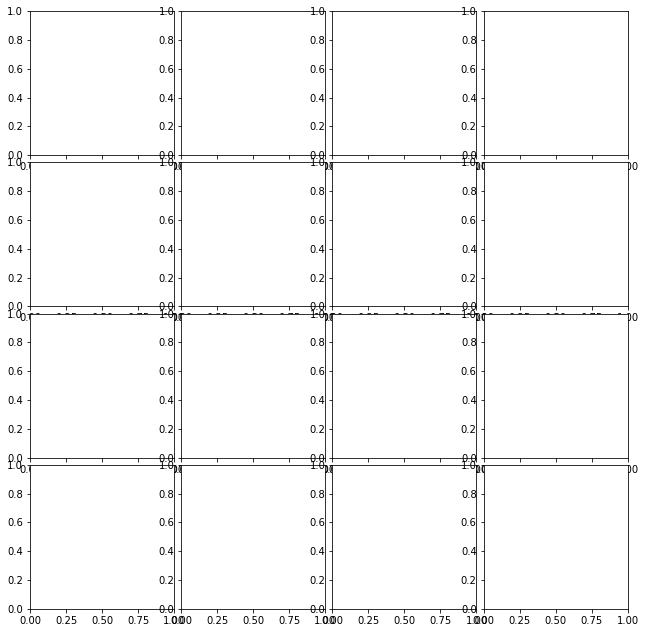

adamet: 10.0 % done; 7.0 % accepted
adamet: 20.0 % done; 22.0 % accepted
adamet: 30.0 % done; 25.7 % accepted
adamet: 40.0 % done; 26.2 % accepted
adamet: 50.0 % done; 27.2 % accepted
adamet: 60.0 % done; 26.2 % accepted
adamet: 70.0 % done; 26.9 % accepted
adamet: 80.0 % done; 27.2 % accepted
adamet: 90.0 % done; 27.2 % accepted
adamet: 100.0 % done; 26.9 % accepted
adamet: done. Total time 371.72 seconds

Best-fitting parameters and 1sigma errors:
   $q_{\rm min}$ = 0.4256 +/- 0.1
   $\beta_z$ = 0.007426 +/- 0.14
   $M_{BH}$ = 2.536e+06 +/- 1.8e+05
   $(M/L)_{\rm tot}$ = 1.392 +/- 0.029


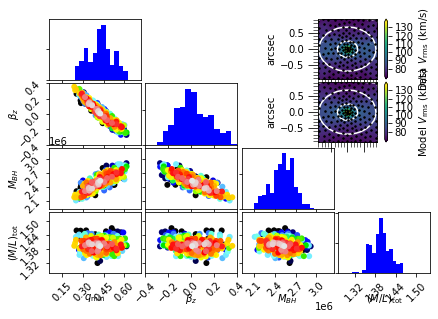

In [5]:

if __name__ == '__main__':

    # This example takes about 8 min on a 2GHz CPU
    jam_bh_adamet_example()